In [18]:
# !pip install -U yt-dlp==2023.1.6 matplotlib==3.6.0 datasets[audio] rich

# install newest transformers build to be able to pass `inputs_embeds` through generate()
# !pip install --upgrade git+https://github.com/huggingface/transformers.git

**Relevant huggingface gpt2 code**

- https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
- https://github.com/huggingface/transformers/blob/main/src/transformers/generation/utils.py
- https://github.com/huggingface/transformers/issues/6535

# Load musiccaps

In [1]:
from musiccaps import load_musiccaps
import numpy as np
from rich import print as printr
from torch.utils.data import DataLoader, Dataset, random_split
import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import itertools
import math
from rich import print as printr
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def filter_muscaps_with_embeddings(ds, embeddings):
    '''Some clips weren't downloaded so we couldn't embed them, get rid of that'''
    exclude_ids = set()
    for i in range(len(ds)):
        if ds[i]['ytid'] not in embeddings.keys():
            exclude_ids.add(i)
    ds = ds.select(
        (
            i for i in range(len(ds)) 
            if i not in set(exclude_ids)
        )
    )
    assert len(ds) == len(embeddings)
    return ds

In [3]:
ds = load_musiccaps(
    './music_data',
    sampling_rate=16000,
    limit=None,
    num_proc=8,
    writer_batch_size=1000,
    return_without_audio=True
)
embeddings = np.load('embeddings.npy', allow_pickle=True).item()

Using custom data configuration google--MusicCaps-7925612b943f961b
Found cached dataset csv (/home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


In [4]:
class CaptionEmbedding(Dataset):
    '''Returns a torch Dataset of paired captions and embeddings'''
    def __init__(self, muscaps_ds, embeddings):
        ds = filter_muscaps_with_embeddings(muscaps_ds, embeddings)
        self.captions = ds.sort(column='ytid')['caption']
        sorted_embs = [value for _, value in sorted(embeddings.items())]
        self.embeddings = torch.from_numpy(np.stack(sorted_embs)).to(device)

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        return self.captions[idx], self.embeddings[idx]

In [5]:
dataset = CaptionEmbedding(muscaps_ds=ds, embeddings=embeddings)

# quick check did not mess up ordering of caption-embedding pairs
# for cap, emb in tqdm(dataset):
#     for i in range(len(ds)):
#         if cap == ds[i]['caption']:
#             assert torch.allclose(emb,torch.from_numpy(embeddings[ds[i]['ytid']]).to(device))

Parameter 'indices'=<generator object filter_muscaps_with_embeddings.<locals>.<genexpr> at 0x7f4fe9ef8580> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


# Training

In [58]:
def tokenize(captions_batch):
    input_ids = tokenizer(captions_batch)['input_ids']
    eos = tokenizer.eos_token_id
     # append eos token, not sure if correct? (maybe wrap it instead?)
    input_ids = [x + [eos] for x in input_ids]
    input_ids = [torch.tensor(t) for t in input_ids]
    # pad with -100, this index should be ignored by the cross-entropy loss func
    input_ids_target = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=-100).to(device)
    
    # index -100 isn't valid for the word embedding
    # so we need a second version as transformer input with -100 replaced with eos
    input_ids = input_ids_target.clone()
    input_ids[input_ids==-100] = eos
    
    # input_ids is prefixed with the actual embedding, so we need to prefix the target too with some token
    # (maybe masked -100 is better)
    input_ids_target = torch.cat([
        torch.full((len(input_ids_target), 1), fill_value=eos, device=device),
        input_ids_target,
    ], dim=1)
    
    return input_ids, input_ids_target

In [59]:
class B2T(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Linear(512, 768),
            nn.ReLU(),
            nn.Linear(768, 768),
            nn.ReLU(),
            nn.Linear(768, 768),
        )
        
    def forward(self, x):
        return self.main(x)

In [60]:
model_name = 'gpt2' # gpt2, gpt2-medium, gpt2-large, gpt2-xl
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
b2t = B2T().cuda()

opt = torch.optim.AdamW([
    {'params': b2t.parameters(), 'lr': 0.0001},
])

generation_params = dict(
    max_length=32,
    num_beams=4,
    do_sample=True,
    temperature=0.95
)

losses = []
bs = 16

dataset = CaptionEmbedding(muscaps_ds=ds, embeddings=embeddings)

train_frac = 0.8
training_data, test_data = random_split(dataset, [train_frac, 1-train_frac])
batch_size = 32
num_epochs = 50
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
eval_train_dataloader = DataLoader(training_data, 1, shuffle=True)
eval_test_dataloader = DataLoader(test_data, 1, shuffle=True)

In [61]:
def eval(data_loader):
    model.eval()
    caption_batch, embedding_batch = next(iter(eval_train_dataloader))
    input_ids, input_ids_target = tokenize(caption_batch)
    
    inputs_embeds = torch.cat([
        b2t(embedding_batch).unsqueeze(1),
        model.transformer.wte(input_ids),
    ], dim=1)
    
    output_ids = model.generate(inputs_embeds=inputs_embeds, **generation_params)
    printr('[blue bold]PRED: ' + tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip())
    printr('[green bold]TRUE: ' + caption_batch[0])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: A man was shot and killed by a group of men in the middle of the night on Tuesday, police said.

The shooting happened around 1 p

TRUE: This audio seems to contain two songs. In the beginning someone is strumming chords on acoustic drums while a
male voice is singing in a high pitch. Then the song switches to a robotic voice sample singing. Then a digital 
drum comes in with a fat kick and bass sound creating the base together with the vocal sample. In the background 
you can hear scratching sounds. This song may be playing while working out.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: "I'm not going to say that I'm not going to say it, but it's going to be hard to hear. It's going to be

TRUE: This song has a bassline that repeats itself playing along with a distorted guitar that supports the melody 
by playing the low notes along with slight variations and licks. The acoustic drums sound in the background but are
played at full force. Fast paced with a lot of hits on different crashes and using a double bass kick. The male 
voice is screaming full force then a synthesizer lead sound is playing a simple melody that is panned to the right 
side of the speakers. This song may be playing at a live-concert jumping up and down enjoying the energetic energy 
of the surrounding and the music.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: "It's a shame that we didn't get a chance to do this, because I'm sure we could have done it better," she 
said. "

TRUE: This folk song features a reed instrument playing the main melody. A similar melody is played on a percussion
instrument by a skilled percussionist. Another percussion instrument plays a tabla-sounding instrument. Cymbals 
also play a melody keeping time with the melody being played. The end of the song features an ascending run on the 
reed and the harmonized percussion.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: The UESPWiki – Your source for The Elder Scrolls since 1995

This page is currently being rewritten as part of the Morrowind Overhaul Project

TRUE: The low quality recording features a manically arpeggiated electric guitar melody and rock playback 
instrumental playing in the background. The recording is very noisy and it was recorded in mono - probably with a 
phone.

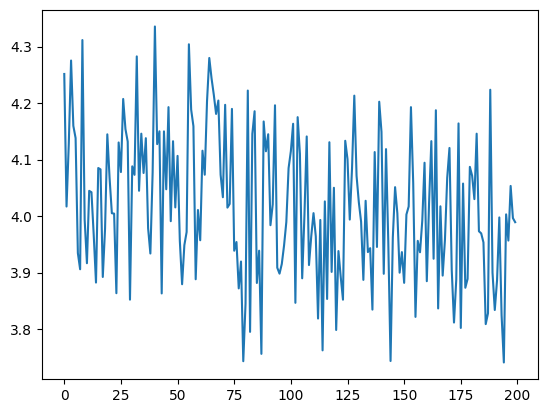

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: This is the first of a two-part series.

A few months ago, I was asked by a friend to write a blog post about the

TRUE: The low quality recording features a reggae song that consists of a flat male vocal, alongside harmonizing 
background male vocals, singing over shimmering shakers, offbeat piano chords, brass melody, wide toms, tinny 
echoing snare and punchy kick layered with it. It sounds upbeat and easygoing.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: There are many ways to make your life easier.

One of the most common ways to do it is to use your smartphone to record the sounds of

TRUE: The song is an instrumental with a smattering of female and male vocals. The song is medium tempo with a 
groovy drum rhythm, church bell accompaniment, slick percussion hits, sustained bass hits, flute playing and vocal 
chants. The song is relaxing. The song is a techno lounge tune.

  0%|          | 0/275 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: We're proud to announce the release of the first of our new releases, the A.R.O.M.E.M.E.M

TRUE: This is a meditation music piece. There is an ambient synth sound playing very faint notes. There are natural
sounds that can be heard in the piece such as the water flowing and the crickets chirping. The atmosphere of the 
piece is relaxing and soothing. The piece would suit perfectly as background music for a meditation video. It could
also be playing in the background at spas and wellness centers.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: Still loading...

A B C D E F G H I J K L M N O P Q R S T U V W X Y Z

TRUE: The Techno track features a punchy "4 on the floor" kick pattern, punchy snare, groovy bass, alongside 
echoing synth keys, short haunting synth lead and weird percussive sound effects. It is groovy and energetic.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: About

This is a game about being able to travel between worlds.

This is a game about being able to travel between worlds.

TRUE: This song contains someone playing a rhythm on a djembe along with a frame drum. Someone is strumming chords 
on guitar while the bagpipes are taking the main melody. Then a male voice starts speaking and the crowd is 
cheering and clapping their hands. This song may be playing live at a traditional concert.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: In the last few years, there have been a lot of changes in technology in the world of virtual reality (VR). 
The first was the introduction of virtual

TRUE: The low quality recording features a live performance of shimmering shakers, acoustic rhythm guitar and 
arpeggiated harp melody. It sounds tropical and exotic even though the recording is very noisy, as it was probably 
recorded with a phone.

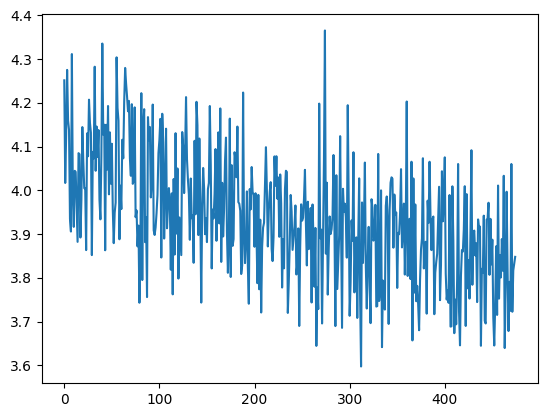

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: This is a rush transcript. Copy may not be in its final form.

AMY GOODMAN: This is Democracy Now!, democracynow.org, The

TRUE: A male African tribal singer sings this melody with female backup singers in vocal harmony. The song is 
medium tempo with percussive African drums in rhythm and other percussion hits. The song is energetic and 
devotional in nature. The audio quality is poor.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: The United States is one of the world's most developed economies. It has a large population of people living 
in developing countries. The United States is also one

TRUE: This song features a male voice narrating a story in the beginning. This is followed by a drum roll in a 
marching beat style. A bass note is played which is the root note of the chord. An organ strikes a chord and plays 
it staccato style. A guitar also strikes a chord. There are no other instruments in this song. This song can be 
played in a movie trailer.

  0%|          | 0/275 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: This is a rush transcript. Copy may not be in its final form.

AMY GOODMAN: This is Democracy Now!, democracynow.org, The

TRUE: The song is music created by a toothbrush. The tempo is medium and sounds like a female singer singing in 
high pitch, motor whirring sounds and button clicks. The audio is poor quality in nature.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: A man is dead after being shot in the head by a group of young men in a suburban Atlanta neighborhood.

The shooting happened around 8:30

TRUE: The Reggae song features harmonizing male vocals singing over wooden percussion, punchy snare and kick hits, 
claps, groovy bass, offbeat piano chords, followed by flat male vocals. It sounds energetic, happy, fun, groovy and
funky.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: This is a game for 2 to 4 players with a mix of guitar and bass. The goal is to play as many songs as 
possible and to keep track

TRUE: This music is instrumental. The tempo is medium with an animated Banjo lead harmony. There is minimal 
instrumentation with cheerful ,popping vibrations of this beautiful instrument. It is lively ,spirited, cheerful 
and adds a beautiful layer to Country and Folk Songs.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: This is a list of all the players who have played in the recent past.

Players who have played in the past 1 or 2 years:

TRUE: The low quality recording features a pop song that consists of a passionate male vocal, alongside harmonizing
background vocals, singing over people cheering sounds, shimmering hi hats, claps, snare rolls, groovy bass and 
wide electric guitar melody. It sounds energetic and exciting.

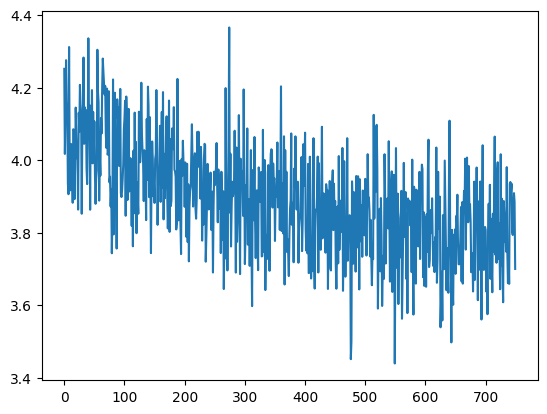

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: The next time you hear a word that sounds like "piano" or "piano-bass" you're probably thinking, "Wow, that 
sounds

TRUE: This is a percussion instrumental. The tempo is medium with the sound of a drum roll on the Chinese Big drum 
or Tanggu . The beat is strong, emphatic and resounding. It has a Royal, Ceremonial or Victorious vibe to it.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: A few weeks ago, I was playing a game with a friend. He was playing a game of chess with a couple of friends.
He was playing a

TRUE: A female vocalist sings this Gospel song. The tempo is medium with groovy bass lines, keyboard accompaniment,
electric guitar and acoustic guitar rhythm,tambourine beats and choral harmony. The song is a 
spirited,emotional,fervent, earnest and devotional Christian Worship Song.

  0%|          | 0/275 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: We are excited to announce that we are partnering with a team of musicians to bring you the first ever video 
game soundtrack to your computer.

We are

TRUE: This is a live recording of a musician playing a Chinese flute, otherwise known as a dizi. It is a calming 
and melodic piece - and you could imagine yourself walking peacefully through marshlands or grasslands. Though the 
melody is enchanting, the audio quality is average - with a slight fuzzy buzz present in the background.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: The US military has announced that it will deploy a large-scale unmanned aerial vehicle (UAV) to Afghanistan 
in the coming weeks.

The US

TRUE: The low quality recording features a live performance of a jazz song and it consists of a saxophone solo 
melody played over mellow keys chords, groovy bass, punchy snare and kick hits and shimmering hi hats. It sounds 
passionate and soulful.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: Description

The first stage of the game consists of a series of 3-minute songs, each consisting of a short melody. The songs 
are arranged into

TRUE: This song features a distortion guitar playing a guitar solo. The solo is played at a high pitch. It is a 
slow tempo solo. The guitarist plays a lot of vibrato when the notes are allowed to ring for a while. The pattern 
follows three ascending notes followed by three strikes on a lower note. This is followed by one higher note, the 
lower note and a hammer on to a higher note. A synth plays backing chords. There are no other instruments in this 
song. The mood of this song is romantic.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: The following is a list of the main topics covered in the video:

What is the purpose of the program?

The purpose of the program

TRUE: This is a gospel piece used as an accompaniment to a tambourine dance. There is a female vocalist singing. 
There is an electric guitar and a xylophone playing the melody. The tune is not very clear due to the quality of 
the recording. The atmosphere is religious. Samples could be lifted from this recording to be used in a beat.

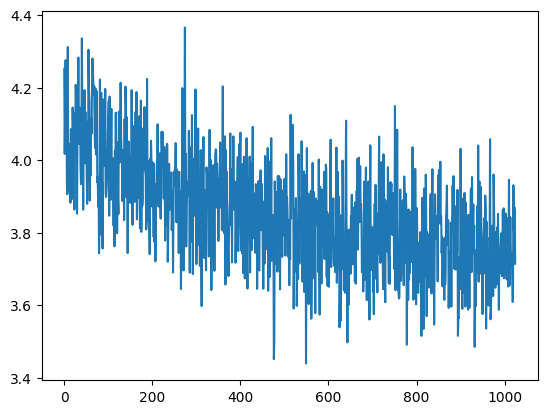

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: The U.S. Postal Service is considering the use of drones to search for hazardous materials in the U.S.

The agency is considering the

TRUE: The low quality recording features a live performance of a classical song and it consists of sustained cello 
melody played over passionate piano melody, after which there is a plucked cello melody. It sounds emotional and 
passionate.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: In this video, you will hear some of the best music of the year.

In this video, you will hear some of the best music of

TRUE: This song contains a male voice singing in a higher pitch, a digital drum string playing a simple repeating 
melody. This song may be playing at home having a romantic time with your partner dancing.

  0%|          | 0/275 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: The UESPWiki – Your source for The Elder Scrolls since 1995


This article is about a/an/remastered version of the game.

TRUE: The low quality recording features a mellow arpeggiated piano melody over which there is a theremin solo 
melody playing. It sounds sad, emotional and passionate. The recording is noisy.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: The following is a list of all the items in the package. Please note that this list is a compilation of all 
the items in the package. If you

TRUE: This song contains drone sounds played by a string instrument and a synth. On top of that a panflute sound is
playing a simple slow melody. A male voice is chanting a mantra in a deeper voice. This song may be playing in a 
meditation session.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: A new study has found that the use of marijuana is associated with a higher risk of heart disease and stroke.

The study, published in the journal

TRUE: The low quality recording features a didgeridoo melody played over wooden percussion and shimmering shaker. 
There are some crowd chattering noises in the background. It is reverberant, due to the fact that it was performed 
in a medium size room, uptempo and the recording is noisy.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: This is the first in a series of series about the history of the Chicago Bears. This is an overview of the 
history of the Bears. The Bears were

TRUE: This audio clip is a harmonica melody with vocalisation.The music is dissonant with the sound of a dog 
howling/whining to the rhythm of the harmonica. It is sweet, entertaining and adorable.

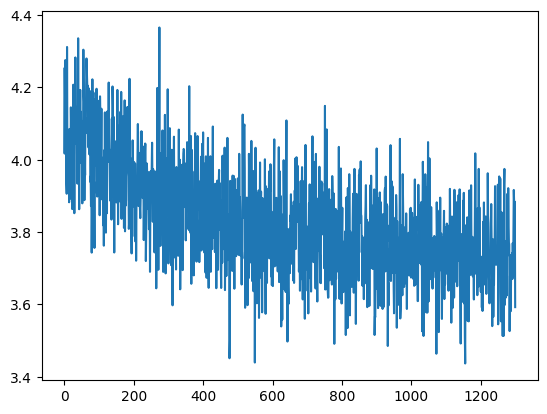

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: A new study published in the journal Environmental Science & Technology finds that there is a direct 
relationship between the number of people in the United States and the number of

TRUE: This is an electronic/downtempo house music piece. There is a male vocalist singing melodically under heavy 
effects. There is a synth and an acoustic guitar playing the repeated main tune. The rhythmic background consists 
of an acoustic drum beat. The atmosphere is trippy. This piece could be used in the soundtrack of an animation 
movie, especially during vivid dream sequences.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PRED: The number of children in the United States has declined by more than 20 percent since the 1990s, according 
to a new report from the National Center for Health

TRUE: This song is a Retro electronic instrumental. The tempo is fast with electronically arranged music, slick 
drumming, bright amplified keyboard harmony, tambourine beats,synthesiser arrangements and male and female 
vocalisation. The song is youthful, groovy,vibrant, upbeat, passionate, catchy and punchy. This song is a Retro 
EDM.

In [62]:
for epoch in tqdm(range(num_epochs)):
    for step, (caption_batch, embedding_batch) in enumerate(tqdm(train_dataloader)):
        input_ids, input_ids_target = tokenize(caption_batch)
        
        inputs_embeds = torch.cat([
            b2t(embedding_batch).unsqueeze(1),
            model.transformer.wte(input_ids),
        ], dim=1)
        
        model.train()
        loss = model.forward(inputs_embeds=inputs_embeds, labels=input_ids_target).loss
        loss.backward()
        opt.step()
        losses.append(loss.item())
        
        if step % 100 == 0:
            eval(eval_train_dataloader)
            eval(eval_test_dataloader)
            print()

        if step % 200 == 199:
            plt.plot(losses)
            plt.show()

---

# random experiments

In [29]:
seq = torch.tensor(tokenizer.encode('List of 10 cute animals: dog, cat, '))
inputs_embeds = model.transformer.wte(seq.cuda()).unsqueeze(0)
#inputs_embeds = torch.cat([weird_word_embedding, inputs_embeds], dim=1)

In [9]:
encoded = tokenizer.batch_encode_plus(['List of 10 cute animals: dog, cat, '], return_tensors='pt')
input_ids = encoded['input_ids'].cuda()
attention_mask = encoded['attention_mask'].cuda()
inputs_embeds = model.transformer.wte(input_ids)

In [42]:
# if you don't pass input_ids here, the output is the same, minus the prompt
outputs = model.generate(inputs_embeds=inputs_embeds, attention_mask=attention_mask, **generation_params)
tokenizer.batch_decode(outputs, skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['ursine, horse, elephant, goat, fish, sheep, pig, chicken, piglet, mouse, rat, rat-tat-tat']

In [34]:
outputs = model.generate(input_ids, **generation_params)
tokenizer.batch_decode(outputs, skip_special_tokens=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['List of 10 cute animals: dog, cat, urchin, fish, frog, rabbit, snake, squid, and bird.\n\n1. Dog']